# Resnet 구현

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block_34(inputs, filters, strides=1, downsample=False):
    identity = inputs
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        identity = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

def resnet_block_50(inputs, filters, strides=1, downsample=False):
    shortcut = inputs
    strides_temp = strides
    if downsample:
        if not filters == 64:
            strides_temp = 2
    
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters*4, (1, 1), strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_block(inputs, filters, strides=1, downsample=False, is_50=False):
    if is_50:
         x = resnet_block_50(inputs, filters, strides=strides, downsample=downsample)
    else:
         x = resnet_block_34(inputs, filters, strides=strides, downsample=downsample)
    return x

def build_resnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = resnet_block(x, filters, strides=strides, downsample=True, is_50=is_50)

        for _ in range(1, num_blocks):
            x = resnet_block(x, filters, is_50=is_50)

    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        x = Dense(num_classes, activation='softmax')(x)
    name = 'Resnet_50' if is_50 else 'Resnet_34'
    model = Model(inputs=inputs, outputs=x, name=name)

    model = Model(inputs=inputs, outputs=x)
    return model


In [2]:
#Build ResNet-34
input_shape = (32, 32, 3)
num_classes = 10

resnet_34 = build_resnet(input_shape, False, num_classes )
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
# Build ResNet-50
input_shape = (32, 32, 3)
num_classes = 10

resnet_50 = build_resnet(input_shape, True, num_classes )
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기

In [4]:
def plain_block_34(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block_50(inputs, filters, strides=1):
    strides_temp = 1
    if strides == 2:
        if not filters == 64:
            strides_temp = 2
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block(inputs, filters, strides=1, is_50=False):
    if is_50:
         x = plain_block_50(inputs, filters, strides=strides)
    else:
         x = plain_block_34(inputs, filters, strides=strides)
    return x

def build_plain(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = plain_block(x, filters, strides=strides, is_50=is_50)

        for _ in range(1, num_blocks):
            x = plain_block(x, filters, is_50=is_50)
    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        x = Dense(num_classes, activation='softmax')(x)
    name = 'Plain_50' if is_50 else 'Plain_34'
    model = Model(inputs=inputs, outputs=x, name=name)
    return model


In [5]:
#Build Plain-34
input_shape = (224, 224, 3)
num_classes = 10

plain_34 = build_plain(input_shape, False, num_classes, True)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256

In [6]:
#Build Plain-50
input_shape = (224, 224, 3)
num_classes = 10

plain_50 = build_plain(input_shape, True, num_classes, False )
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_139 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_140 (Bat (None, 56, 56, 64)        256

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import urllib3
import tensorflow_datasets as tfds

urllib3.disable_warnings()

# Load the tf_flowers dataset
dataset_name = 'tf_flowers'
train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

# Preprocess the images and create batches
batch_size = 32
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
input_shape = (224, 224, 3)
num_classes = 5

In [9]:
resnet_34 = build_plain(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_resnet(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 67s 202ms/step - loss: 1.6558 - accuracy: 0.2606 - val_loss: 206.9525 - val_accuracy: 0.1894
Epoch 2/10
92/92 [==============================] - 17s 181ms/step - loss: 1.5113 - accuracy: 0.3048 - val_loss: 16.3778 - val_accuracy: 0.1921
Epoch 3/10
92/92 [==============================] - 17s 184ms/step - loss: 1.4641 - accuracy: 0.3147 - val_loss: 15.1517 - val_accuracy: 0.3324
Epoch 4/10
92/92 [==============================] - 17s 181ms/step - loss: 1.4026 - accuracy: 0.3702 - val_loss: 1.9314 - val_accuracy: 0.1962
Epoch 5/10
92/92 [==============================] - 17s 179ms/step - loss: 1.3020 - accuracy: 0.4087 - val_loss: 2.9111 - val_accuracy: 0.2916
Epoch 6/10
92/92 [==============================] - 17s 180ms/step - loss: 1.2890 - accuracy: 0.4298 - val_loss: 2.3788 - val_accuracy: 0.2262
Epoch 7/10
92/92 [==============================] - 17s 180ms/step - loss: 1.2195 - accuracy: 0.4615 - val_loss: 2.1429 - val_accuracy: 0.

In [13]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 41s 380ms/step - loss: 1.6797 - accuracy: 0.4370 - val_loss: 1.6006 - val_accuracy: 0.3638
Epoch 2/10
92/92 [==============================] - 32s 346ms/step - loss: 1.3243 - accuracy: 0.5279 - val_loss: 9.1520 - val_accuracy: 0.2289
Epoch 3/10
92/92 [==============================] - 32s 344ms/step - loss: 1.1744 - accuracy: 0.5412 - val_loss: 8.6971 - val_accuracy: 0.5668
Epoch 4/10
92/92 [==============================] - 32s 347ms/step - loss: 1.1666 - accuracy: 0.5729 - val_loss: 66.0233 - val_accuracy: 0.2657
Epoch 5/10
92/92 [==============================] - 32s 345ms/step - loss: 1.1487 - accuracy: 0.5889 - val_loss: 16.3506 - val_accuracy: 0.4850
Epoch 6/10
92/92 [==============================] - 32s 344ms/step - loss: 0.9940 - accuracy: 0.6369 - val_loss: 1.8955 - val_accuracy: 0.4959
Epoch 7/10
92/92 [==============================] - 32s 346ms/step - loss: 0.8846 - accuracy: 0.6628 - val_loss: 2.0807 - val_accuracy: 0.49

In [14]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 20s 186ms/step - loss: 1.6409 - accuracy: 0.2640 - val_loss: 90.2525 - val_accuracy: 0.1826
Epoch 2/10
92/92 [==============================] - 17s 181ms/step - loss: 1.4347 - accuracy: 0.3460 - val_loss: 6.6806 - val_accuracy: 0.1989
Epoch 3/10
92/92 [==============================] - 17s 181ms/step - loss: 1.3574 - accuracy: 0.3992 - val_loss: 32.3184 - val_accuracy: 0.1839
Epoch 4/10
92/92 [==============================] - 17s 180ms/step - loss: 1.3240 - accuracy: 0.4206 - val_loss: 7.6701 - val_accuracy: 0.2357
Epoch 5/10
92/92 [==============================] - 17s 180ms/step - loss: 1.3126 - accuracy: 0.4465 - val_loss: 4.7822 - val_accuracy: 0.2439
Epoch 6/10
92/92 [==============================] - 17s 180ms/step - loss: 1.2395 - accuracy: 0.4697 - val_loss: 1.3033 - val_accuracy: 0.4305
Epoch 7/10
92/92 [==============================] - 17s 180ms/step - loss: 1.1987 - accuracy: 0.5054 - val_loss: 3.1663 - val_accuracy: 0.40

In [15]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 38s 356ms/step - loss: 1.8512 - accuracy: 0.4329 - val_loss: 2.3517 - val_accuracy: 0.3965
Epoch 2/10
92/92 [==============================] - 32s 347ms/step - loss: 1.2727 - accuracy: 0.5034 - val_loss: 2.1116 - val_accuracy: 0.3651
Epoch 3/10
92/92 [==============================] - 32s 347ms/step - loss: 1.2393 - accuracy: 0.5266 - val_loss: 1.2070 - val_accuracy: 0.5613
Epoch 4/10
92/92 [==============================] - 32s 347ms/step - loss: 1.1572 - accuracy: 0.5715 - val_loss: 2.7462 - val_accuracy: 0.4523
Epoch 5/10
92/92 [==============================] - 32s 347ms/step - loss: 1.1744 - accuracy: 0.5467 - val_loss: 4.3462 - val_accuracy: 0.3147
Epoch 6/10
92/92 [==============================] - 32s 348ms/step - loss: 1.0164 - accuracy: 0.6202 - val_loss: 1.5091 - val_accuracy: 0.5259
Epoch 7/10
92/92 [==============================] - 32s 347ms/step - loss: 0.9219 - accuracy: 0.6543 - val_loss: 3.3817 - val_accuracy: 0.5395

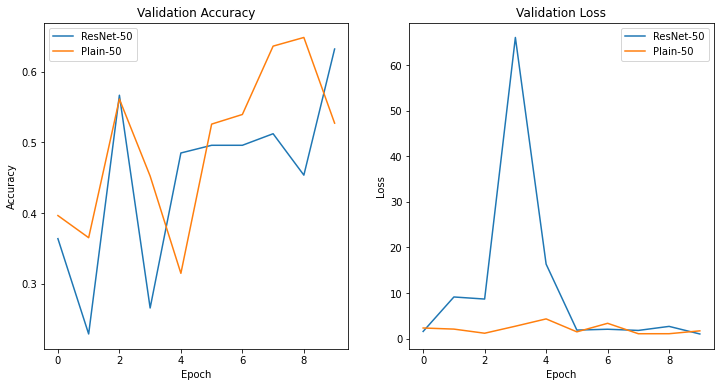

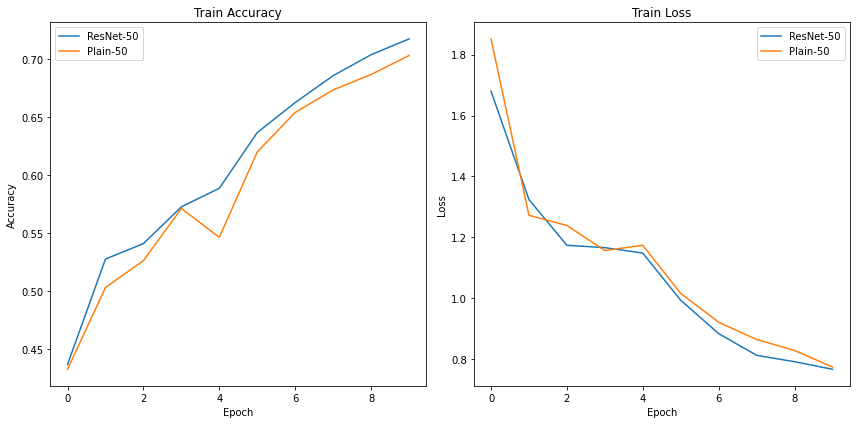

In [17]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

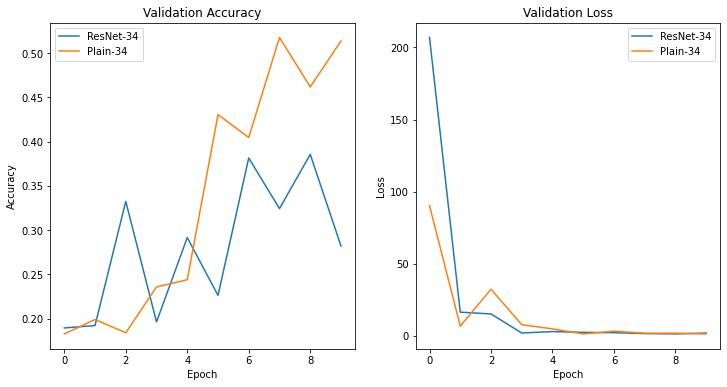

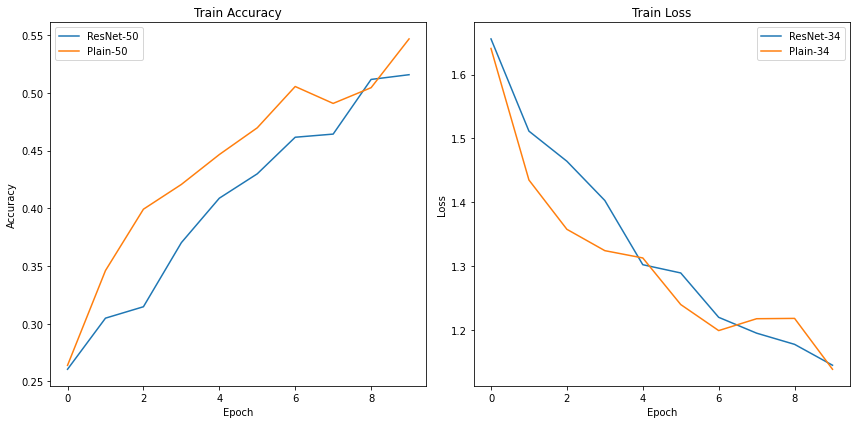

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()